In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4105 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 0 3 3 3 3 1 0 1 1 2 2 0 2 0 3 1 2 1 2 0 3 0 2 0 1 3 3 1 2 2 0]


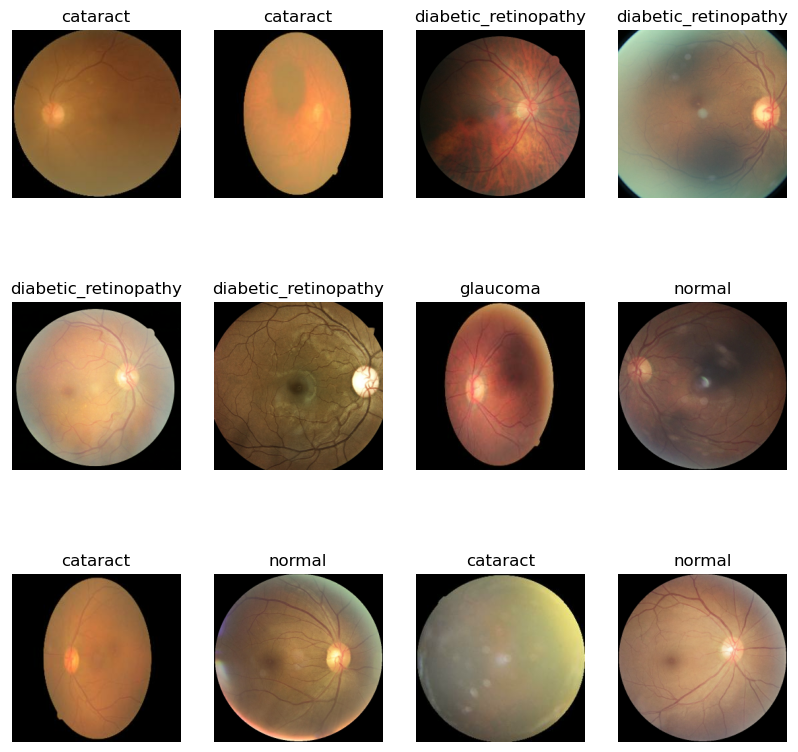

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

129

In [9]:
train_size = 0.8
len(dataset)*train_size

103.2

In [10]:
train_ds = dataset.take(105)
len(train_ds)

105

In [11]:
test_ds = dataset.skip(105)
len(test_ds)

24

In [12]:
val_size=0.1
len(dataset)*val_size

12.9

In [13]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [14]:
test_ds = test_ds.skip(13)
len(test_ds)

11

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

103

In [18]:
len(val_ds)

12

In [19]:
len(test_ds)

14

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (2,2), activation='relu', input_shape=input_shape, padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 128, 128, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 126, 126, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 63, 63, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 61, 61, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3,
)

Epoch 1/3
103/103 [==============================] - 233s 2s/step - loss: 1.1019 - accuracy: 0.5049 - val_loss: 1.0953 - val_accuracy: 0.5234
Epoch 2/3
103/103 [==============================] - 217s 2s/step - loss: 0.8656 - accuracy: 0.6016 - val_loss: 0.8291 - val_accuracy: 0.6484
Epoch 3/3
103/103 [==============================] - 225s 2s/step - loss: 0.7442 - accuracy: 0.6633 - val_loss: 0.8149 - val_accuracy: 0.6068


In [43]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 31s 284ms/step - loss: 0.7704 - accuracy: 0.6741


In [49]:
scores

[0.7704407572746277, 0.6741071343421936]

In [50]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

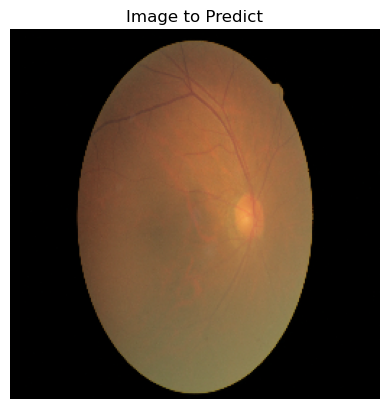

1/1 [==============================] - 1s 624ms/step
cataract: 23.40%
diabetic_retinopathy: 6.74%
glaucoma: 68.49%
normal: 1.37%


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
def predict_and_display(model, class_names, image_path, img_height, img_width):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  

    plt.imshow(img)
    plt.title('Image to Predict')
    plt.axis('off')
    plt.show()

    predictions = model.predict(img_array)[0] 
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[i] * 100:.2f}%")


class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

img_height = 256
img_width = 256

image_path_to_predict = r"C:\Users\swej\Desktop\1037.png" 
# Replace with your image path

predict_and_display(model, class_names, image_path_to_predict, img_height, img_width)


In [60]:
model.save("fundus.h5")